In [1]:
import pandas as pd
import numpy as np
import os
import re

In [2]:
def room_division(dataRoom):
    """
    room_division
    -------------
    take all the data and divide the rooms of all PoliTo
    ### Output:
        - the dataframe with the room divided
    """
    Ap = "AP-AULA"
    dataRoom = dataRoom[dataRoom["name_ap"].notnull()]
    dataRoom = dataRoom[dataRoom["name_ap"].str.contains(Ap)]
    rooms = pd.DataFrame()
    rooms[["AP", "Room", "APnum", "NaN"]] = dataRoom["name_ap"].str.split(
        "-", expand=True
    )
    dataRoom = pd.concat([dataRoom, rooms], axis=1)
    dataRoom = dataRoom.drop(["AP", "NaN"], axis=1)
    return dataRoom

In [3]:
df = pd.read_csv("ml_data/03_11_2024_11_37_03_AULA3P_54.csv")
df = room_division(df)
df["Room"].unique()

array(['AULAR4', 'AULA1S', 'AULAR3', 'AULA5T', 'AULA4P', 'AULA3I',
       'AULA2I', 'AULA7T', 'AULA3P', 'AULA4I', 'AULA1M', 'AULA12A',
       'AULAR1', 'AULA13S', 'AULA05', 'AULA7', 'AULAR2B', 'AULA9T',
       'AULAR3B', 'AULA4T', 'AULAR4B', 'AULA1I', 'AULA9I', 'AULA5I',
       'AULA2', 'AULA15A', 'AULA10A', 'AULA7S', 'AULA27', 'AULA14',
       'AULA16', 'AULA3M', 'AULA4', 'AULA11', 'AULA1P', 'AULA03',
       'AULA11S', 'AULA23', 'AULA4N', 'AULA19A', 'AULA11I', 'AULAR1B',
       'AULA4M', 'AULASTUDIOR2', 'AULA27B', 'AULA2T', 'AULA10I', 'AULA08',
       'AULA12I', 'AULA29B', 'AULA10', 'AULA4C', 'AULA11T', 'AULA2N',
       'AULA13', 'AULA8C', 'AULA29', 'AULA2M', 'AULA5S', 'AULA5D',
       'AULA01', 'AULA17A', 'AULA7B', 'AULA6', 'AULA6I', 'AULA3D',
       'AULA4D', 'AULA3S', 'AULA10D', 'AULA3N', 'AULA5M', 'AULA13B',
       'AULASTUDIO3', 'AULA11B', 'AULASTUDIOR1', 'AULA9B', 'AULA6N',
       'AULA5B', 'AULA25', 'AULA9S', 'AULA8D', 'AULA5N', 'AULA15',
       'AULA1B', 'AULA1T', 'AULA7I', 'A

In [4]:
dataset_dict = {
    "aula": [],
    "n_devices": [],
    "n_users": [],
    "snr_mean": [],
    "snr_std": [],
    "rssi_mean": [],
    "rssi_std": [],
    "ch_util_2_4_mean": [],
    "ch_util_5_mean": [],
    "noise_2_4_mean": [],
    "noise_5_mean": [],
    "n_people": []
}

path = "ml_data/"
regex_aula = "(AULA.+)_"
regex_n_people = "_([0-9]+)\."


for i, file in enumerate(os.listdir(path)):
    df = pd.read_csv(path + file)
    df.drop(columns=["Unnamed: 0", "Timestamp_y", "ch_2_4", "ch_5", "class", "domain", "client_type", "code_ap"], inplace=True)
    df = room_division(df)

    aula = re.search(regex_aula, file).group(1)
    df_aula = df[df["Room"] == aula]

    if len(df_aula) == 0:
        print(f"{aula} is empty. Skipping the acquisition!")
        continue
    dataset_dict["aula"].append(aula)

    # Feature extrapolation
    df_dist_ap = df_aula.drop_duplicates(subset="APnum")
    n_devices = df_dist_ap["n_clients_2_4"].sum() + df_dist_ap["n_clients_5"].sum()
    dataset_dict["n_devices"].append(n_devices)

    df_dist_users = df_aula.drop_duplicates(subset="user_masked")
    n_users = len(df_dist_users[df_dist_users["snr"] > 20])
    dataset_dict["n_users"].append(n_users)

    snr_mean = df_aula["snr"].mean()
    dataset_dict["snr_mean"].append(snr_mean)
    snr_std = df_aula["snr"].std()
    dataset_dict["snr_std"].append(snr_std)

    rssi_mean = df_aula["rssi"].mean()
    dataset_dict["rssi_mean"].append(rssi_mean)
    rssi_std = df_aula["rssi"].std()
    dataset_dict["rssi_std"].append(rssi_std)

    ch_util_2_4_mean = df_dist_ap["ch_utilization_2_4"].mean()
    dataset_dict["ch_util_2_4_mean"].append(ch_util_2_4_mean)
    ch_util_5_mean = df_dist_ap["ch_utilization_5"].mean()
    dataset_dict["ch_util_5_mean"].append(ch_util_5_mean)

    noise_2_4_mean = df_dist_ap["noise_2_4"].mean()
    dataset_dict["noise_2_4_mean"].append(noise_2_4_mean)
    noise_5_mean = df_dist_ap["noise_5"].mean()
    dataset_dict["noise_5_mean"].append(noise_5_mean)


    x = re.search(regex_n_people, file)
    n_people = int(x.group(1))
    dataset_dict["n_people"].append(n_people)

In [5]:
dataset = pd.DataFrame.from_dict(dataset_dict)
dataset

,aula,n_devices,n_users,snr_mean,snr_std,rssi_mean,rssi_std,ch_util_2_4_mean,ch_util_5_mean,noise_2_4_mean,noise_5_mean,n_people
0,AULA3I,3.0,2,34.000000,5.567764,-57.666667,5.507571,11.666667,15.000000,-90.333333,-90.333333,2
1,AULA7S,123.0,84,42.611570,7.513734,-51.115702,6.344538,38.333333,8.333333,-86.500000,-93.666667,127
2,AULA3P,122.0,87,40.188034,6.497920,-51.393162,5.997064,32.500000,27.500000,-84.500000,-92.250000,111
3,AULAR2,183.0,112,36.335196,7.321620,-53.027933,6.093310,37.750000,5.500000,-81.000000,-90.500000,150
4,AULA3I,6.0,4,34.800000,4.438468,-57.400000,4.449719,15.333333,5.333333,-93.666667,-89.666667,3
...,...,...,...,...,...,...,...,...,...,...,...,...
63,AULAR4,90.0,60,38.858824,5.486245,-51.294118,5.254983,50.250000,16.250000,-90.500000,-92.750000,76
64,AULA2P,85.0,59,42.240964,7.032313,-51.156627,7.106304,35.000000,5.250000,-83.000000,-93.500000,80
65,AULA11S,35.0,21,36.875000,8.507113,-54.687500,7.689278,46.000000,14.000000,-86.000000,-90.000000,23
66,AULA9I,29.0,18,31.285714,7.437927,-60.892857,6.511183,14.000000,3.500000,-92.000000,-90.000000,18


<Axes: >

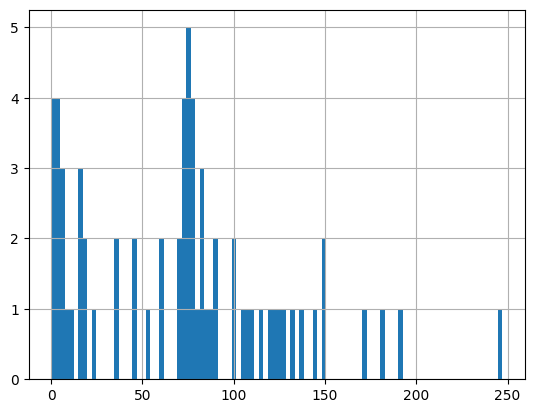

In [6]:
dataset["n_people"].hist(bins=100)

#### Comparison with baseline

In [7]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

print("r2:",r2_score(dataset["n_people"], dataset["n_users"]))
print("MAPE: ",mean_absolute_percentage_error(dataset["n_people"], dataset["n_users"]) )

r2: 0.7415100246733681
MAPE:  132458812569720.86


In [8]:
y = dataset["n_people"].to_numpy()# + (np.random.rand(len(dataset)) * 0.001)
dataset.drop(["aula", "n_people"], axis=1, inplace=True)
X = dataset.to_numpy()# + (np.random.rand(len(dataset), len(dataset.columns)) * 0.001)

### TODO
- Choice of regression model at this [link](https://medium.com/@dnyaneshwalwadkar/regression-a-to-z-choosing-the-correct-type-of-regression-analysis-4cfb29ae5a1)
- Cross validation [here](https://scikit-learn.org/stable/modules/cross_validation.html)

In [9]:
from sklearn.model_selection import train_test_split

#### Static split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.14)
print("Train shape: ", X_train.shape)
print("Test shape: ", X_test.shape)
y_test

Train shape:  (58, 10)
Test shape:  (10, 10)


array([137,  89, 114,  46, 125,  60,   0, 150, 111,  54])

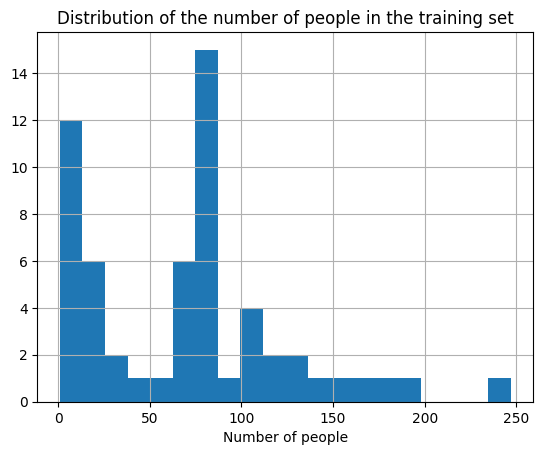

In [38]:
import matplotlib.pyplot as plt
plt.title("Distribution of the number of people in the training set")
plt.hist(y_train, bins=20)
plt.xlabel("Number of people")
plt.grid()

#### Linear regression

In [39]:
from sklearn.linear_model import LinearRegression

In [50]:
lin_reg_model = LinearRegression()
fitted = lin_reg_model.fit(X_train, y_train)

In [56]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
print("R2 train: ", fitted.score(X_train, y_train))
print("R2 test: ", fitted.score(X_test, y_test))
print("MAE train:", mean_absolute_error(fitted.predict(X_train), y_train))
print("MAE test:", mean_absolute_error(fitted.predict(X_test), y_test))
print("RMSE train:", root_mean_squared_error(fitted.predict(X_train), y_train))
print("RMSE test:", root_mean_squared_error(fitted.predict(X_test), y_test))


R2 train:  1.0
R2 test:  -3.8737687767710858
MAE train: 6.975291723531407e-09
MAE test: 88.6
RMSE train: 8.840511342014104e-09
RMSE test: 99.38007848658603


#### Cross validation

In [15]:
from sklearn.model_selection import cross_val_score, ShuffleSplit
cv = ShuffleSplit(n_splits=3, test_size=0.1)


In [172]:
scores = cross_val_score(lin_reg_model, X, y, cv=cv)
scores

array([ 0.86168981,  0.19272549, -0.56853424])

In [42]:
mean_absolute_percentage_error(y_test, fitted.predict(X_test))

1929546425323891.2

### Gaussian process regression

In [54]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [55]:
gaus_reg_model = GaussianProcessRegressor()
fitted = gaus_reg_model.fit(X_train, y_train)
fitted.score(X_test, y_test)
fitted.predict(X_train)

array([ 35.        ,  78.99999999,   3.        ,   7.        ,
       181.99999998,  79.99999999,   8.        ,  69.99999999,
         3.        ,  76.99999999, 148.99999999,  15.        ,
       122.99999999,  35.        ,  18.        , 246.99999998,
        90.99999999,  74.99999999,  11.        , 118.99999999,
         3.        , 105.99999999, 100.99999999,  75.99999999,
        23.        ,  74.99999999, 131.99999999,   6.        ,
        76.99999999,  72.99999999,  70.99999999,   1.        ,
        76.99999999, 126.99999999,  45.        ,   3.        ,
        71.99999999, 191.99999998,  81.99999999, 107.99999999,
        17.        ,   2.        ,  75.99999999,  82.99999999,
        60.99999999,   2.        ,  99.99999999,  75.99999999,
        81.99999999,  86.99999999,  16.        ,  71.99999999,
        84.99999999,   5.        ,  72.99999999,  18.        ,
       171.99999998, 143.99999999])

In [45]:
scores = cross_val_score(gaus_reg_model, X, y, cv=cv)
scores

NameError: name 'cv' is not defined

In [46]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_train, fitted.predict(X_train))

9.873967336053595e-11

### Random Forest Regressor

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, ShuffleSplit


In [48]:
rf_regr = RandomForestRegressor()
fitted_rf = rf_regr.fit(X,y)

In [20]:
cv = ShuffleSplit(n_splits=3, test_size=0.1)
scores = cross_val_score(rf_regr, X, y, cv=cv)

In [21]:
scores

array([0.81454182, 0.92142385, 0.93112278])

In [49]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score
print(mean_absolute_percentage_error(y_test, fitted_rf.predict(X_test)))
print(r2_score(y_test, fitted_rf.predict(X_test)))


535928355657089.0
0.9867411667752315


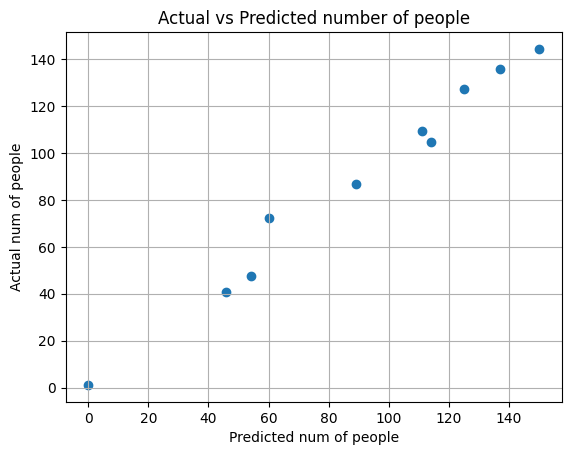

In [28]:
import matplotlib.pyplot as plt
plt.scatter(y_test, fitted_rf.predict(X_test))
plt.grid()
plt.ylabel('Actual num of people')
plt.xlabel('Predicted num of people')
plt.title('Actual vs Predicted number of people')
plt.show()

In [22]:
y_test

array([137,  89, 114,  46, 125,  60,   0, 150, 111,  54])

In [21]:
i = 25
fitted_rf.predict(X_test)

array([135.73,  86.97, 104.51,  40.92, 127.45,  72.49,   1.16, 144.33,
       109.41,  47.7 ])

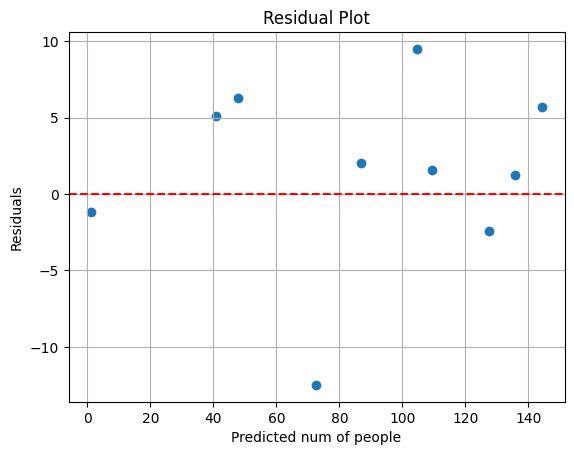

In [29]:
residuals = y_test - fitted_rf.predict(X_test)
plt.scatter(fitted_rf.predict(X_test), residuals)
plt.grid()
plt.xlabel('Predicted num of people')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [32]:
import pickle
pickle.dump(fitted_rf, open("../Service/sub/ml_models/random_forest.sav", 'wb'))

In [33]:
load_model = pickle.load(open("../Service/sub/ml_models/random_forest.sav",'rb'))

In [34]:
load_model

RandomForestRegressor()

In [35]:
load_model.predict(X_train[i:27,:])

array([ 12.07, 176.32])